# Blockchain Data Statistical Analysis 

AFKATM, Uton Hackathon 2019

<img src="image.png" width="420" height="200">

In [271]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare data

Load the data and apply z-score normalization. 

Z-score normalization aims to format data to mean=0 and std=1 which allows to compare different series in a unified way.

In [272]:
onchain = pd.read_csv('data/onchain.csv')
onchain = onchain[onchain.eth_priceUsd.notna()].set_index('datetime')
onchain.index = onchain.index.astype('datetime64[ns]')

onchain['btc_priceUsd'] = onchain[['btc_priceUsd']].apply(zscore)
onchain['eth_priceUsd'] = onchain[['eth_priceUsd']].apply(zscore)
onchain['inOutDifference'] = onchain[['inOutDifference']].apply(zscore)

In [273]:
atm = pd.read_csv('data/data_clean.csv')
atm['date'] = atm['date'].astype('datetime64[ns]')
atm = atm.set_index(['date', 'atm_name'])

atm['amount_total'] = atm[['amount_total']].apply(zscore)

# Examen seasonality in the data

Applying seasonal decomposition of the data. 

The idea beneath seasonal decomposition is to state that any series can be decomposed in a sum (or a product) of 3 components: a trend, a seasonal component, and residuals. 

Here we examine seasonal component only.

### Visual analysis

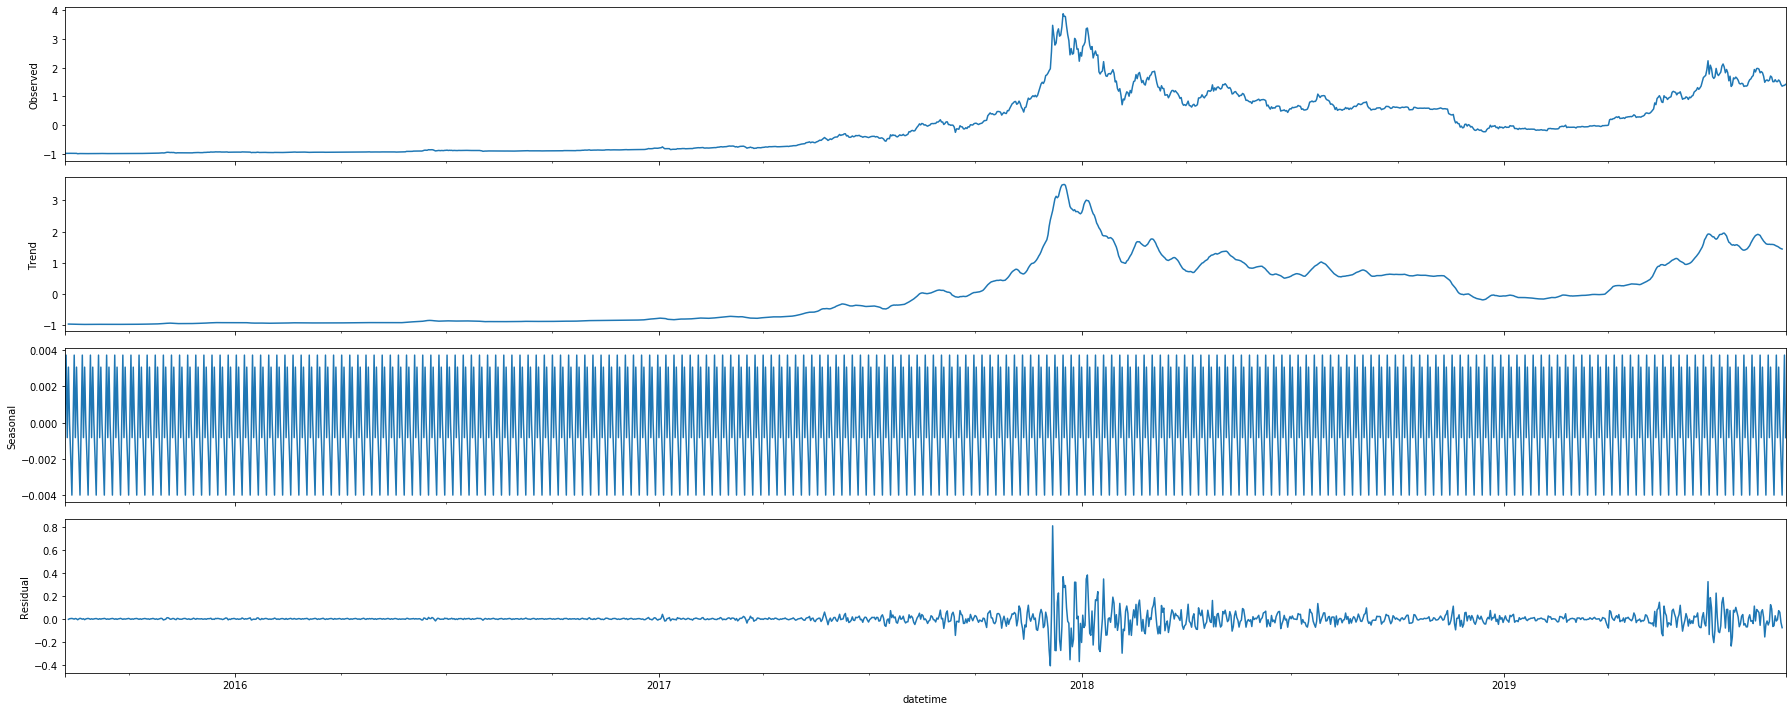

In [274]:
btc_price_series = sm.tsa.seasonal_decompose(onchain['btc_priceUsd'], model='additive')

plt.rcParams['figure.figsize'] = (25.0, 10.0)
btc_price_series.plot();

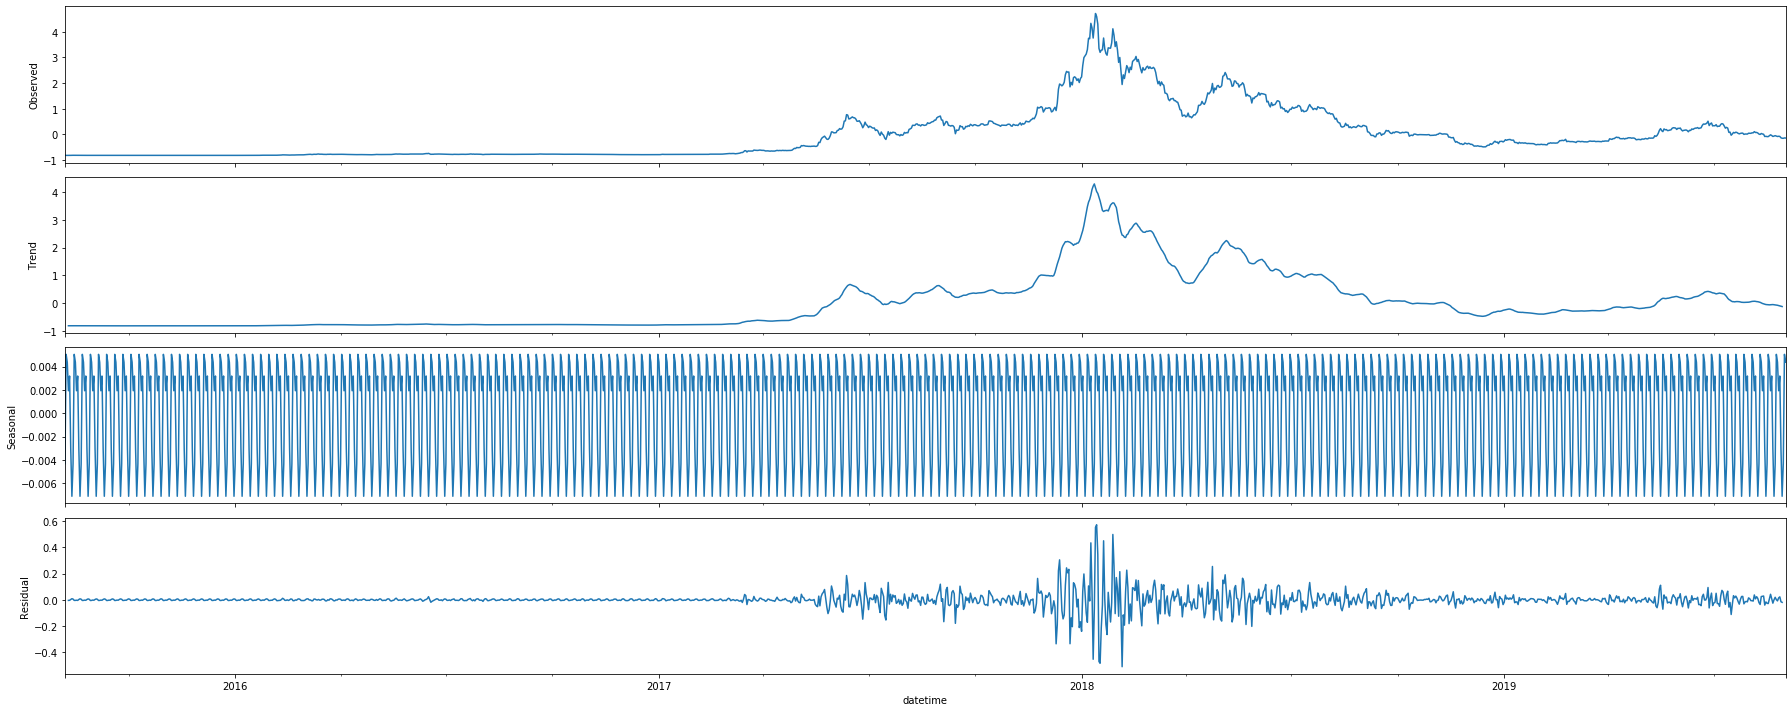

In [275]:
eth_price_series = sm.tsa.seasonal_decompose(onchain['eth_priceUsd'], model='additive')

plt.rcParams['figure.figsize'] = (25.0, 10.0)
eth_price_series.plot();

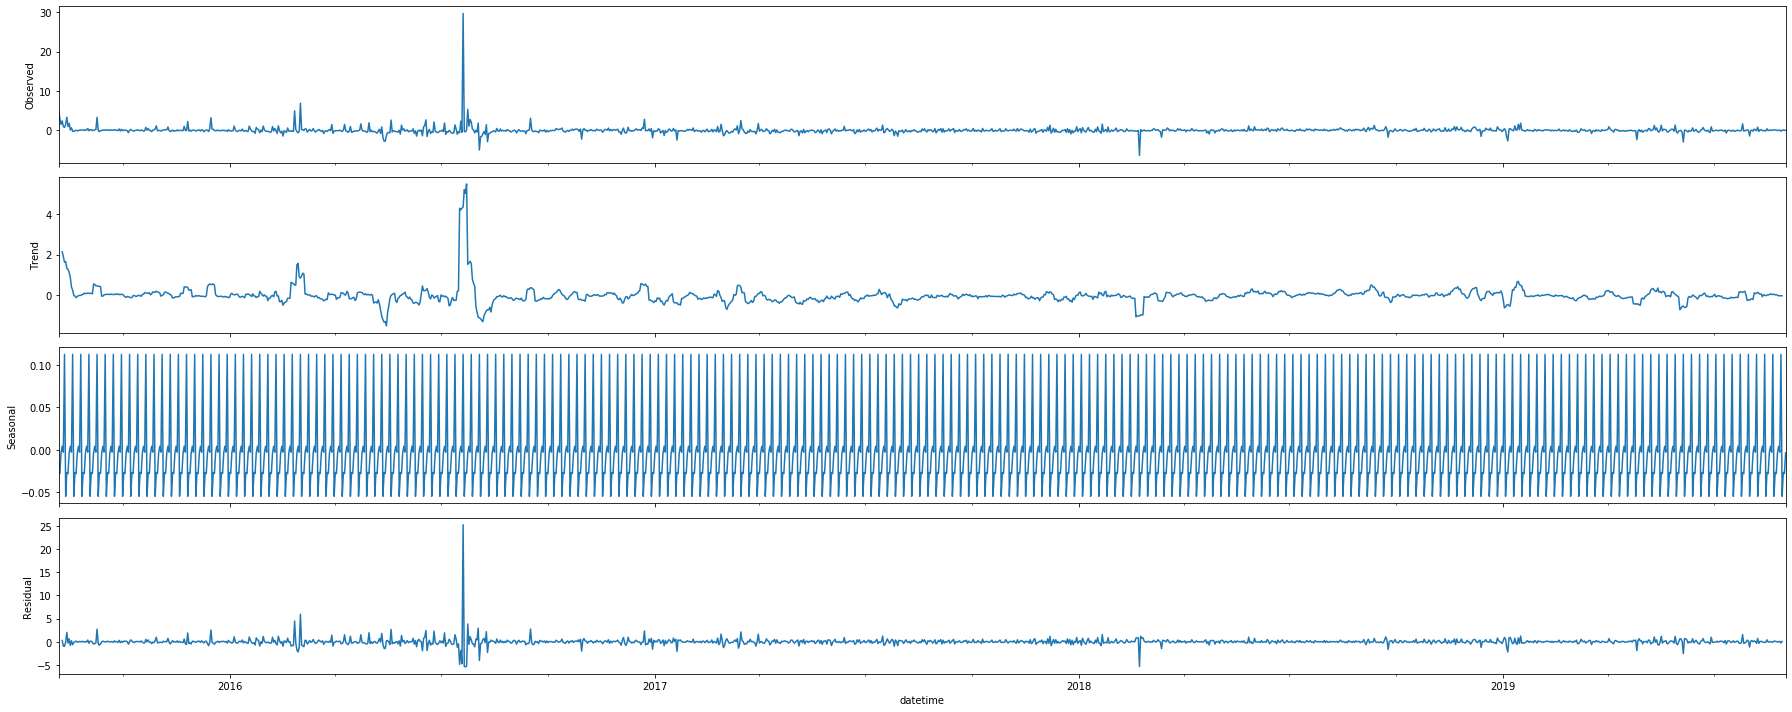

In [276]:
ex_flow_series = sm.tsa.seasonal_decompose(onchain['inOutDifference'], model='additive')

plt.rcParams['figure.figsize'] = (25.0, 10.0)
ex_flow_series.plot();

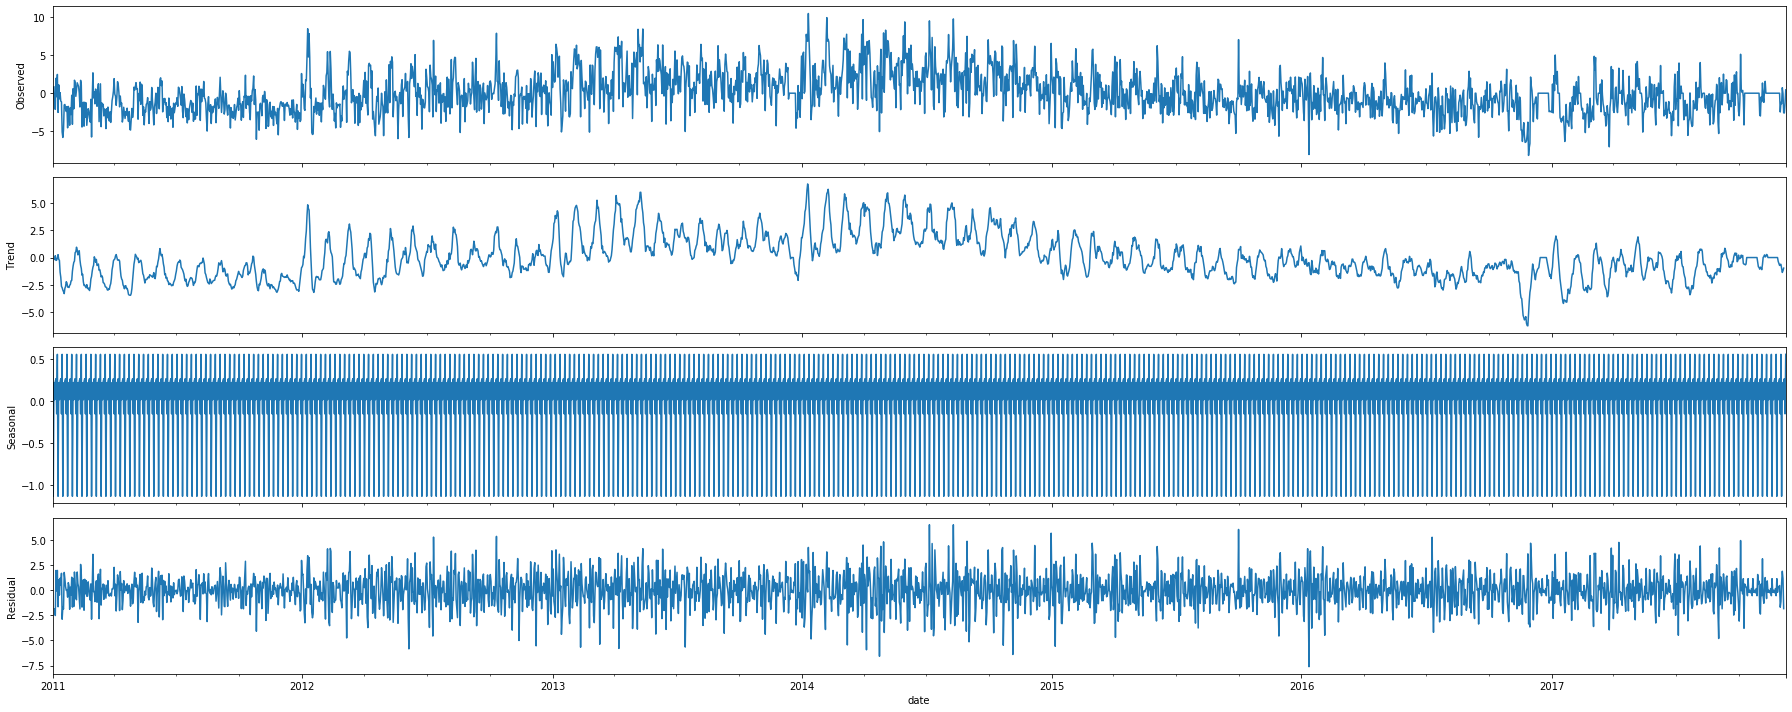

In [277]:
atm_series = sm.tsa.seasonal_decompose(atm.groupby('date').sum()['amount_total'], model='additive')

plt.rcParams['figure.figsize'] = (25.0, 10.0)
atm_series.plot();

### Get coefficients of the seasonal component

In [278]:
from sklearn.metrics.pairwise import cosine_similarity

# use linear approximation to get daily seasonal coefficients
from sklearn import linear_model

In [279]:
df = pd.DataFrame([
    btc_price_series.seasonal,
    eth_price_series.seasonal,
    ex_flow_series.seasonal,
    atm_series.seasonal
]).T
df['weekday'] = df.index.weekday

To avoid multicollinearity encode weekday. 

Day 0 (Monday) shows 'base' level while other days coefficients show fluctuations around day 0.

In [280]:
df['day1'] = df['weekday'].apply(lambda x: 1 if x == 1 else 0)
df['day2'] = df['weekday'].apply(lambda x: 1 if x == 2 else 0)
df['day3'] = df['weekday'].apply(lambda x: 1 if x == 3 else 0)
df['day4'] = df['weekday'].apply(lambda x: 1 if x == 4 else 0)
df['day5'] = df['weekday'].apply(lambda x: 1 if x == 5 else 0)
df['day6'] = df['weekday'].apply(lambda x: 1 if x == 6 else 0)

df['day0'] = 1

In [281]:
reg_btc = linear_model.LinearRegression()
btc_price_reg = reg_btc.fit(
    X=np.array(df[df.btc_priceUsd.notna()][['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6']]), 
    y=np.array(df[df.btc_priceUsd.notna()]['btc_priceUsd']).reshape(-1, 1),    
)

reg_eth = linear_model.LinearRegression()
eth_price_reg = reg_eth.fit(
    X=np.array(df[df.eth_priceUsd.notna()][['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6']]), 
    y=np.array(df[df.eth_priceUsd.notna()]['eth_priceUsd']).reshape(-1, 1),
    
)

reg_flow = linear_model.LinearRegression()
flow_reg = reg_flow.fit(
    X=np.array(df[df.inOutDifference.notna()][['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6']]), 
    y=np.array(df[df.inOutDifference.notna()]['inOutDifference']).reshape(-1, 1),
    
)

reg_amount = linear_model.LinearRegression()
atm_reg = reg_amount.fit(
    X=np.array(df[df.amount_total.notna()][['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6']]), 
    y=np.array(df[df.amount_total.notna()]['amount_total']).reshape(-1, 1),
    
)

In [282]:
coef = pd.DataFrame([
    btc_price_reg.coef_[0],
    eth_price_reg.coef_[0],
    flow_reg.coef_[0],
    atm_reg.coef_[0],
], index=['btc', 'eth', 'flow', 'atm'])

## Analyze similarity of seasonal components of onchain features and ATM withdrawals.

In [285]:
results = pd.DataFrame(cosine_similarity(coef))

results.columns = ['BTC_price', 'ETH_price', 'Ex_flow', 'ATM_withdrawals']
results.index = ['BTC_price', 'ETH_price', 'Ex_flow', 'ATM_withdrawals']

In [286]:
# DIFFERENCE in vectors
results.style.background_gradient()

,BTC_price,ETH_price,Ex_flow,ATM_withdrawals
BTC_price,1,0.72479,0.00419932,0.447431
ETH_price,0.72479,1,0.0341031,-0.0390971
Ex_flow,0.00419932,0.0341031,1,0.0601202
ATM_withdrawals,0.447431,-0.0390971,0.0601202,1


Seasonal components of ATM withdrawals volume and Exchange Flow are quite simialar.

It proves the assumption about similar dynamics of funds flow to/from ATMs and exchanges.